In [1]:
# input: iturbide_gaia-data
# output: manual-periodogram

import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

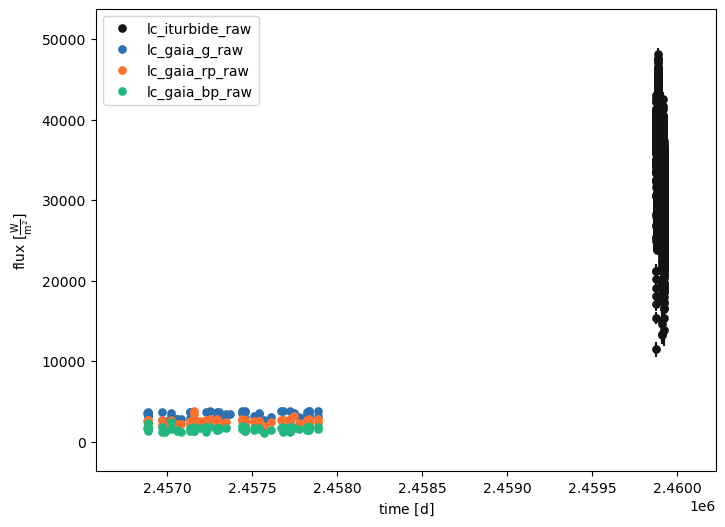

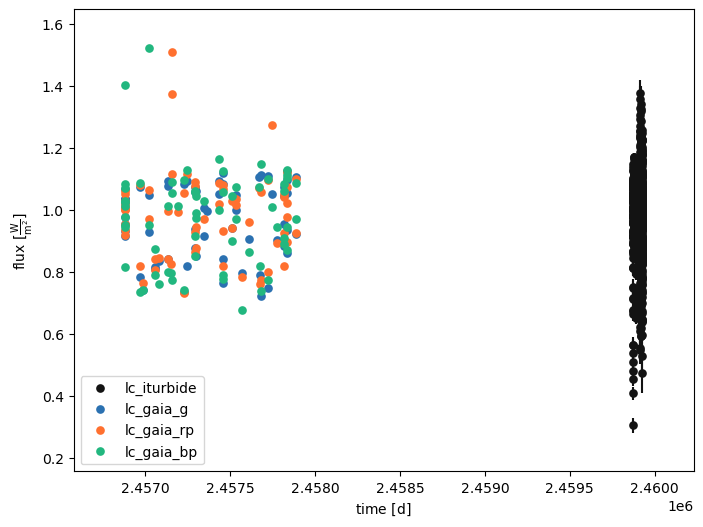

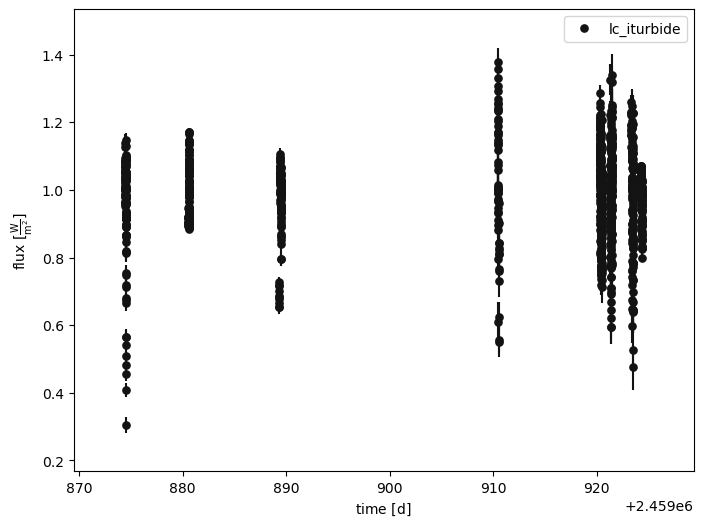

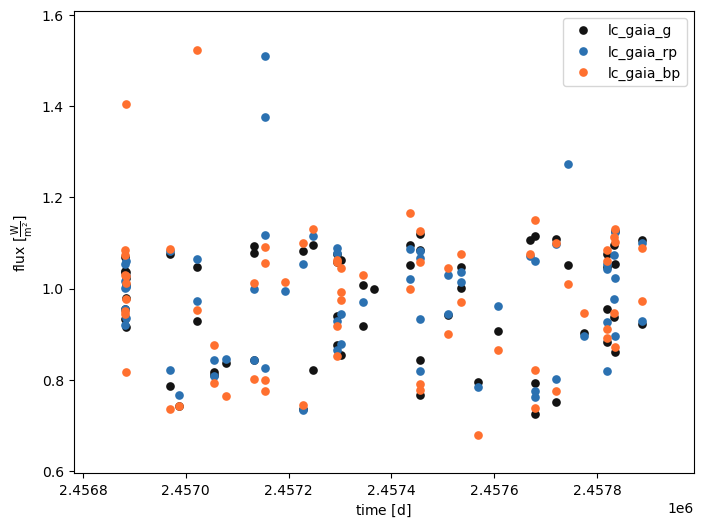

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [2]:
b = phoebe.load("../bundle-saves/iturbide_gaia-data")
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' in d], show=True, legend=True, marker='.')
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')

b.plot(dataset='lc_iturbide', show=True, legend=True, marker='.')
b.plot(dataset=[d for d in b.datasets if 'gaia' in d and 'raw' not in d], show=True, legend=True, marker='.')

In [3]:
iturbideTimes = b.get_value(qualifier='times', dataset='lc_iturbide')

MIN_FREQ = 0.001 # avoiding zero
MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec

N_0 = 5
GRID_SIZE = N_0 * (iturbideTimes[-1] - iturbideTimes[0]) * float(MAX_FREQ)

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = phoebe.linspace(MIN_FREQ, 2, int(GRID_SIZE), endpoint=False)
sub2 = phoebe.linspace(2, float(MAX_FREQ), int(GRID_SIZE) // 100)
manualPeriodSample = np.concatenate([sub1, sub2])

len(manualPeriodSample), manualPeriodSample[0], manualPeriodSample[-1]

(181502, 0.001, 720.0000000000001)

## Iturbide only

In [4]:
[b.disable_dataset(d) for d in b.datasets if d != 'mesh01']
# b.enable_dataset('lc_iturbide')
b.enable_dataset('lc_iturbide_raw')
print(b['enabled'])

ParameterSet: 18 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@mesh01@fast_compute...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide@fast_co...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_raw@fas...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_g@fast_comp...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_rp@fast_com...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_bp@fast_com...: False
   enabled@lc_gaia_g_raw@phoeb...: False
   enabled@lc_gaia_g_raw@fast_...: False
   enabled@lc_gaia_rp_raw@phoe...: False
   enabled@lc_gaia_rp_raw@fast...: False
   enabled@lc_gaia_bp_raw@phoe...: False
   enabled@lc_gaia_bp_raw@fast...: False


### Auto periodogram

ParameterSet: 0 parameters
NO PARAMETERS
ParameterSet: 0 parameters
NO PARAMETERS


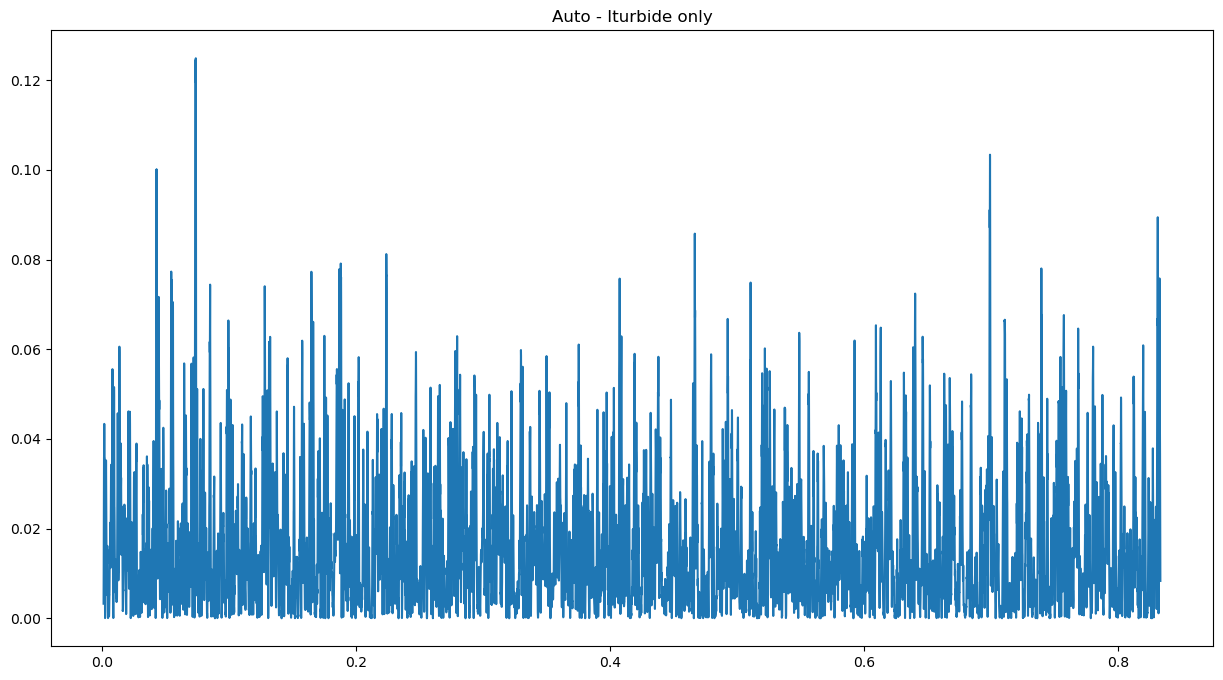

In [6]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_auto', overwrite=True, algorithm='ls')
b.run_solver('lcperiod_iturbide_auto', solution='lcperiod_iturbide_auto_solution', overwrite=True)
plt.plot(b.get_value('period@lcperiod_iturbide_auto_solution'), b.get_value('power@lcperiod_iturbide_auto_solution'))
plt.title("Auto - Iturbide only")
plt.show()

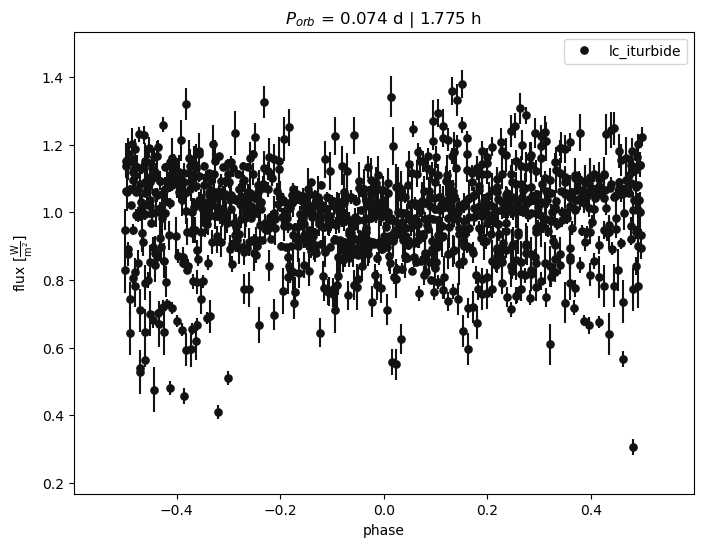

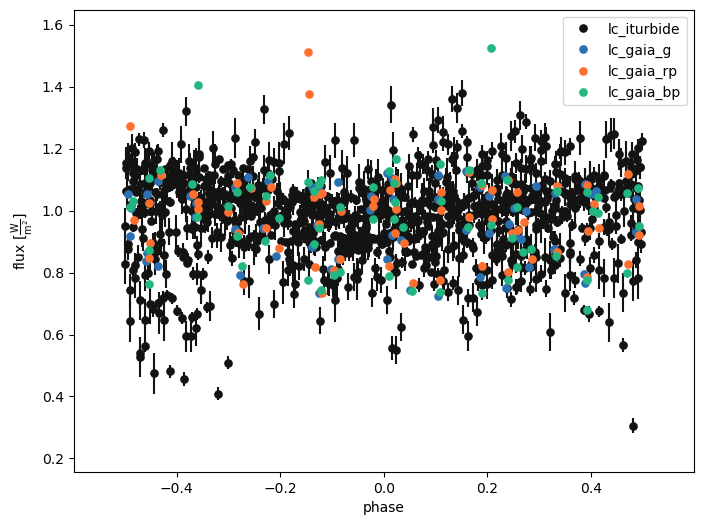

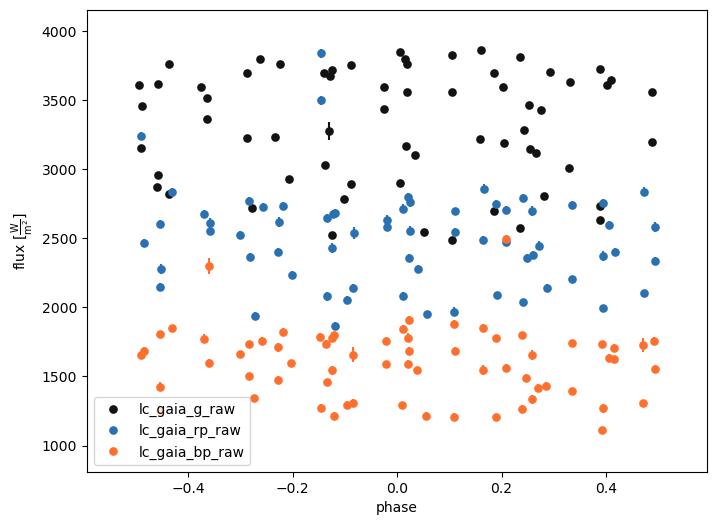

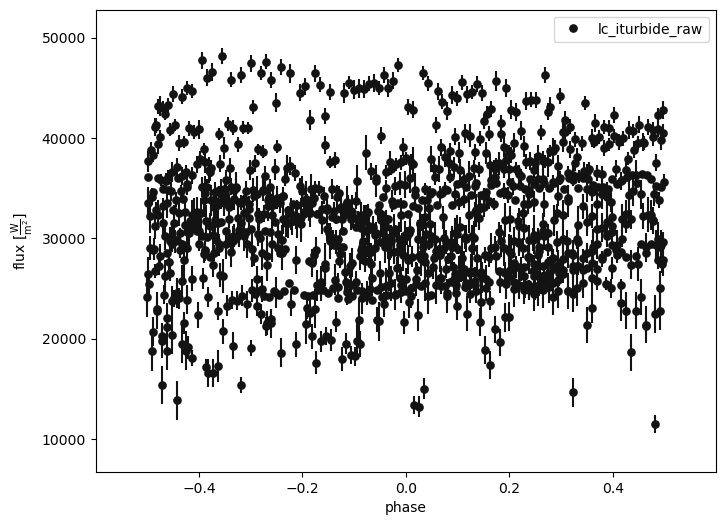

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [7]:
b.adopt_solution('lcperiod_iturbide_auto_solution', period_factor=1)
period = b.get_quantity(qualifier='period', component='binary')
gen_utils.phasePlotEnabledData(b)
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' in d and 'gaia' in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

### Manual frequency grid

In [47]:
# temporarily remove sigmas
sigmas = b.get_value(qualifier='sigmas', dataset='lc_iturbide')

In [92]:
b.set_value(qualifier='sigmas', dataset='lc_iturbide', value=[])

In [99]:
b.set_value(qualifier='sigmas', dataset='lc_iturbide', value=sigmas)

In [11]:
# avoid clutter when printing solver parameters
if 'lcperiod_iturbide_manual_solution' in b.solutions:
    b.remove_solution('lcperiod_iturbide_manual_solution')

b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_manual', overwrite=True,
             algorithm='ls', sample_mode='manual',
             sample_periods=manualPeriodSample)
print(b.filter(solver='lcperiod_iturbide_manual'))

ParameterSet: 8 parameters
   comments@lcperiod_iturbide_...: 
   use_server@lcperiod_iturbid...: none
   algorithm@lcperiod_iturbide...: ls
   lc_datasets@lcperiod_iturbi...: ['*']
   lc_combine@lcperiod_iturbid...: median
   component@lcperiod_iturbide...: binary
   sample_mode@lcperiod_iturbi...: manual
   sample_periods@lcperiod_itu...: [1.00000000e-03
 1.01112379e-03
 1.02224757e-03 ...
 7.19200445e+02
 7.19600223e+02
 7.20000000e+02] d


Parameter: t0@system
                       Qualifier: t0
                     Description: Time at which all values are provided.  For values with time-derivatives, this defines their zero-point.
                           Value: 0.0 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component
                      Related to: t0_supconj@binary@component, period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component

ParameterSet: 10 parameters
R  period@lcperiod_iturbide_ma...: [7.20000000e+02
 7.19600223e+02
 7.19200445e+02 ...
 1.02224757e-03
 1.01112379e-03
 1.00000000e-03] d
R  power@lcperiod_iturbide_man...: [0.00766227 0.00773246
 0.00780329 ...
 0.02172729 0.00161619
 0.00690712]
   period_factor@lcperiod_itur...: 1.0
R  fitted_twigs@lcperiod_iturb...: 

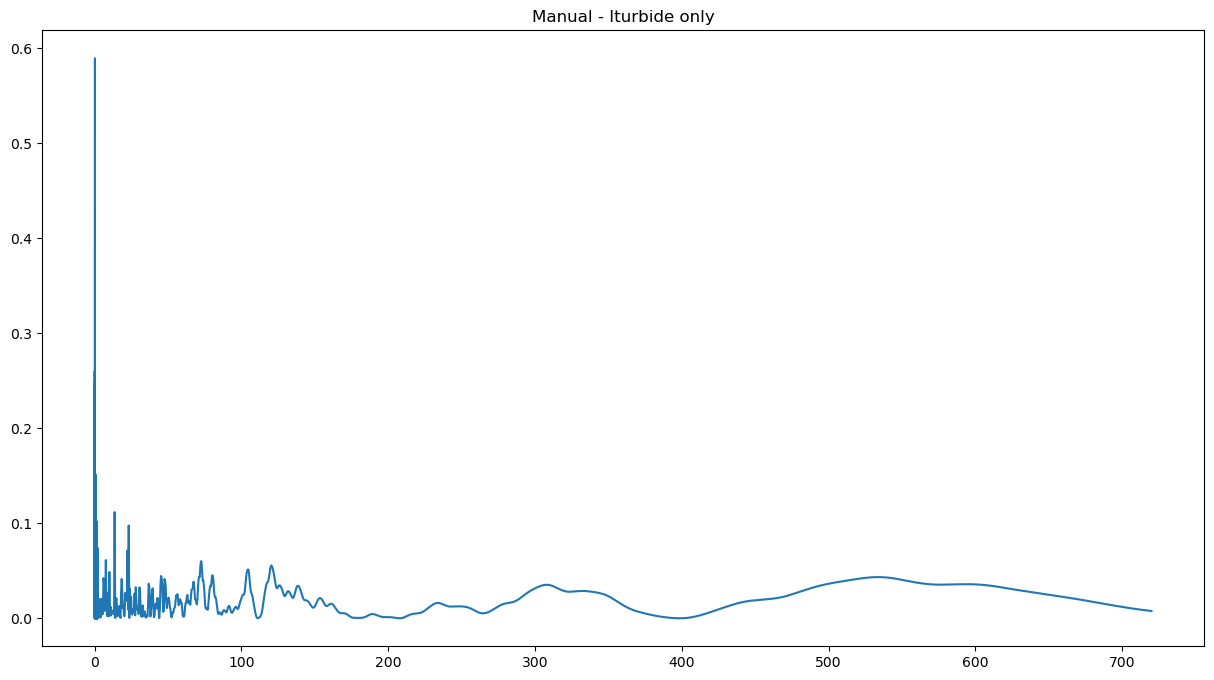

In [16]:
b.run_solver('lcperiod_iturbide_manual', solution='lcperiod_iturbide_manual_solution', overwrite=True)
print(b['t0'])
print(b['lcperiod_iturbide_manual_solution'])
plt.plot(b.get_value('period@lcperiod_iturbide_manual_solution'), b.get_value('power@lcperiod_iturbide_manual_solution'))
plt.title("Manual - Iturbide only")
plt.show()

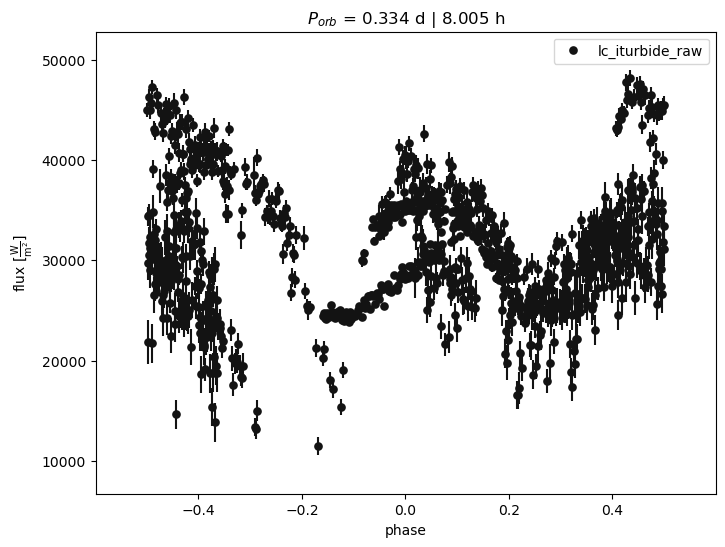

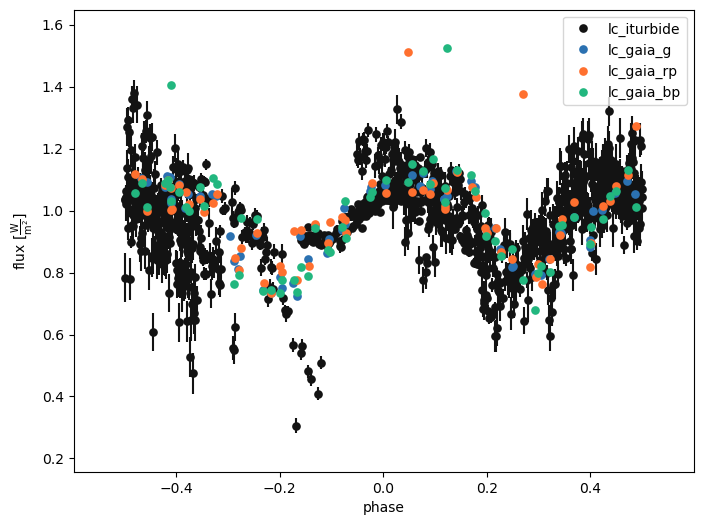

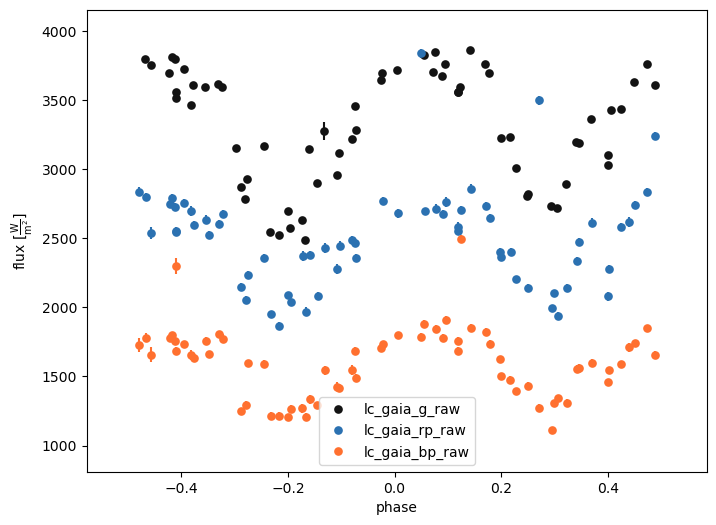

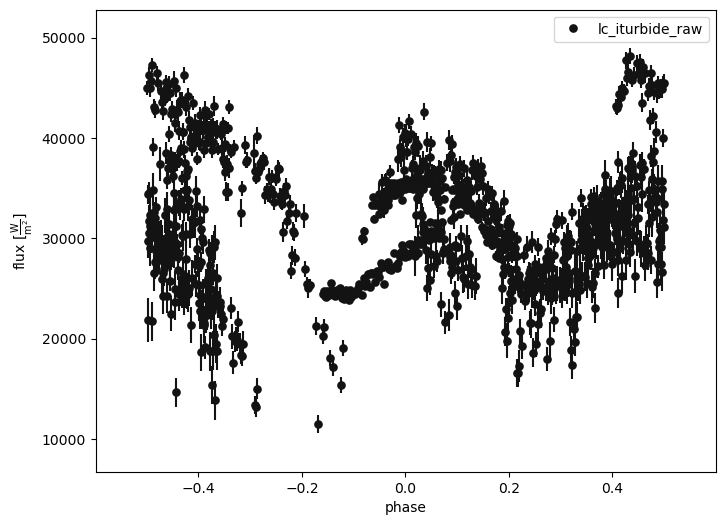

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [13]:
b.adopt_solution('lcperiod_iturbide_manual_solution', period_factor=2)
period = b.get_quantity(qualifier='period', component='binary')
gen_utils.phasePlotEnabledData(b)
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' in d and 'gaia' in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

In [138]:
# re-enabling Gaia datasets, periodogram above looks to have caught the true period that matches Gaia and Iturbide observations
for dataset in b.datasets:
    if "raw" not in dataset:
        b.set_value_all(qualifier='enabled', dataset=dataset, value=True)

print(b['enabled'])

ParameterSet: 18 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@mesh01@fast_compute...: True
   enabled@lc_iturbide@phoebe0...: True
   enabled@lc_iturbide@fast_co...: True
   enabled@lc_iturbide_raw@pho...: False
   enabled@lc_iturbide_raw@fas...: False
   enabled@lc_gaia_g@phoebe01@...: True
   enabled@lc_gaia_g@fast_comp...: True
   enabled@lc_gaia_rp@phoebe01...: True
   enabled@lc_gaia_rp@fast_com...: True
   enabled@lc_gaia_bp@phoebe01...: True
   enabled@lc_gaia_bp@fast_com...: True
   enabled@lc_gaia_g_raw@phoeb...: False
   enabled@lc_gaia_g_raw@fast_...: False
   enabled@lc_gaia_rp_raw@phoe...: False
   enabled@lc_gaia_rp_raw@fast...: False
   enabled@lc_gaia_bp_raw@phoe...: False
   enabled@lc_gaia_bp_raw@fast...: False


In [139]:
b.save("./bundle-saves/manual-periodogram")

'./bundle-saves/manual-periodogram'